In [1]:
# Preamble (system)
import sys
import os

if sys.version_info[0] < 3:
  raise AssertionError('Please run this notebook with Python 3.')

# Preamble (tools)
import numpy as np
import collections
import contextlib
import functools
import itertools
import more_itertools

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Preamble (ML)
np.random.seed(2027)  # set random seed

import tensorflow as tf
tf.random.set_seed(2027)  # set random seed

import dask
import dask.array as da

In [2]:
# Preamble (EMTF)
from emtf_nbtools import get_logger, get_colormap, emtf_nbtools

try:
  import emtf_nnet
except ImportError:
  raise ImportError('Could not import emtf_nnet. It can be found at '
                    'https://github.com/jiafulow/emtf-nnet')

# Get plot style and color map
plt.style.use('tdrstyle.mplstyle')
cm = get_colormap()

# Get logger
logger = get_logger()
logger.info('Using cmssw      : {}'.format(os.environ.get('CMSSW_VERSION', 'N/A')))
logger.info('Using python     : {}'.format(sys.version.replace('\n', '')))
logger.info('Using numpy      : {}'.format(np.__version__))
logger.info('Using matplotlib : {}'.format(matplotlib.__version__))
logger.info('Using tensorflow : {}'.format(tf.__version__))
logger.info('Using keras      : {}'.format(tf.keras.__version__))
logger.info('.. list devices  : {}'.format(tf.config.list_physical_devices()))
logger.info('Using dask       : {}'.format(dask.__version__))
logger.info('Using emtf-nnet  : {}'.format(emtf_nnet.__version__))

[INFO    ] Using cmssw      : CMSSW_11_1_7
[INFO    ] Using python     : 3.9.7 (default, Sep 16 2021, 13:09:58) [GCC 7.5.0]
[INFO    ] Using numpy      : 1.20.3
[INFO    ] Using matplotlib : 3.4.2
[INFO    ] Using tensorflow : 2.6.0
[INFO    ] Using keras      : 2.6.0
2021-09-30 14:19:15.026295: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-09-30 14:19:15.026347: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (login4.ufhpc): /proc/driver/nvidia/version does not exist
[INFO    ] .. list devices  : [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[INFO    ] Using dask       : 2021.08.1
[INFO    ] Using emtf-nnet  : 0.0.2-dev


In [3]:
# Settings

# zone: (0,1,2) -> eta=(1.98..2.5, 1.55..1.98, 1.2..1.55)
zone = 0
#zone = 1
#zone = 2

# timezone: (0,1,2) -> BX=(0,-1,-2)
timezone = 0

#maxevents = 100
maxevents = -1

#workers = 1
workers = 8

# Input files
signal_fname = 'signal.210922.npz'
signal_dxy_fname = 'signal_dxy.210922.npz'
bkgnd_fname = 'bkgnd.210922.npz'

# Model files
patterns_fname = 'patterns_zone%i.npz' % zone
nnet_model_fname = 'quant_nnet_model.json'

logger.info('Using settings   : |')
logger.info('.. zone          : {}'.format(zone))
logger.info('.. timezone      : {}'.format(timezone))
logger.info('.. maxevents     : {}'.format(maxevents))
logger.info('.. workers       : {}'.format(workers))

[INFO    ] Using settings   : |
[INFO    ] .. zone          : 0
[INFO    ] .. timezone      : 0
[INFO    ] .. maxevents     : -1
[INFO    ] .. workers       : 8


### Load data

In [4]:
def load_signal(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    out_part = loaded['out_part']
    out_hits_values = loaded['out_hits_values']
    out_hits_row_splits = loaded['out_hits_row_splits']
    out_hits_shape = (out_hits_row_splits.shape[0] - 1,) + (None,) + out_hits_values.shape[1:]
    out_simhits_values = loaded['out_simhits_values']
    out_simhits_row_splits = loaded['out_simhits_row_splits']
    out_simhits_shape = (out_simhits_row_splits.shape[0] - 1,) + (None,) + out_simhits_values.shape[1:]
  logger.info('out_part: {}, out_hits: {}, out_simhits: {}'.format(
      (out_part.shape, out_part.dtype.name),
      (out_hits_shape, out_hits_values.dtype.name),
      (out_simhits_shape, out_simhits_values.dtype.name)))
  return (out_part, (out_hits_values, out_hits_row_splits), (out_simhits_values, out_simhits_row_splits))


def load_bkgnd(fname):
  logger.info('Loading from {}'.format(fname))
  with np.load(fname) as loaded:
    bkg_aux = loaded['out_aux']
    bkg_hits_values = loaded['out_hits_values']
    bkg_hits_row_splits = loaded['out_hits_row_splits']
    bkg_hits_shape = (bkg_hits_row_splits.shape[0] - 1,) + (None,) + bkg_hits_values.shape[1:]
  logger.info('bkg_aux: {} bkg_hits: {}'.format(
      (bkg_aux.shape, bkg_aux.dtype.name),
      (bkg_hits_shape, bkg_hits_values.dtype.name)))
  return (bkg_aux, (bkg_hits_values, bkg_hits_row_splits))

In [5]:
# Load data
out_part, out_hits, out_simhits = load_signal(signal_fname)

bkg_aux, bkg_hits = load_bkgnd(bkgnd_fname)

[INFO    ] Loading from signal.210922.npz
[INFO    ] out_part: ((2000000, 10), 'float32'), out_hits: ((2000000, None, 17), 'int32'), out_simhits: ((2000000, None, 17), 'int32')
[INFO    ] Loading from bkgnd.210922.npz
[INFO    ] bkg_aux: ((12592764, 2), 'int32') bkg_hits: ((12592764, None, 17), 'int32')


In [6]:
class PatternHelper(object):
  """Reshapes patterns for use in NN."""
  def get_reshaped_patterns(self, patterns):
    patterns = patterns[3]  # prompt patterns only
    patterns = patterns[[3, 2, 4, 1, 5, 0, 6]]  # ordered by straightness
    return patterns  # shape is (7, 8, 3)

  def get_reshaped_patt_filters(self, patt_filters):
    patt_filters = patt_filters[3]  # prompt patterns only
    patt_filters = patt_filters[[3, 2, 4, 1, 5, 0, 6]]  # ordered by straightness
    patt_filters = np.transpose(patt_filters, [3, 2, 1, 0])  # kernel shape is HWCD
    return patt_filters  # shape is (1, 111, 8, 7)

  def get_reshaped_patt_activations(self, patt_activations):
    patt_activations = patt_activations // 4  # from 8-bit to 6-bit
    po2_coeffs = (2 ** np.arange(8))  # [1,2,4,8,16,32,64,128]
    patt_activations[0] = 0  # set to zero if empty hit
    patt_activations[po2_coeffs] = 0  # set to zero if single hit
    assert patt_activations.max() == (64 - 1)
    return patt_activations  # shape is (256,)


def load_patterns():
  num_emtf_zones = 3
  helper = PatternHelper()

  patterns = []
  patt_filters = []
  patt_activations = []
  for z in range(num_emtf_zones):
    fname = patterns_fname.replace('zone%i' % zone, 'zone%i' % z)  # modify filename
    logger.info('Loading from {}'.format(fname))
    with np.load(fname) as loaded:
      patterns.append(helper.get_reshaped_patterns(loaded['patterns']))
      patt_filters.append(helper.get_reshaped_patt_filters(loaded['patt_filters']))
      patt_activations.append(helper.get_reshaped_patt_activations(loaded['patt_activations']))

  patterns = np.asarray(patterns)
  patt_filters = np.asarray(patt_filters)
  patt_activations = np.asarray(patt_activations)
  logger.info('patterns: {} patt_filters: {} patt_activations: {}'.format(
      patterns.shape, patt_filters.shape, patt_activations.shape))

  # Dump constants
  pattern_bank = emtf_nnet.keras.utils.PatternBank(patterns, patt_filters, patt_activations)
  emtf_nnet.keras.utils.save_pattern_bank(pattern_bank)  # write to file
  loaded_pattern_bank = emtf_nnet.keras.utils.load_pattern_bank('pattern_bank.json')
  return loaded_pattern_bank


def load_nnet_model():
  from emtf_nnet.keras.quantization import default_quantize_scheme
  path = nnet_model_fname
  w_path = path.replace('.json', '_weights.h5')
  custom_objects = default_quantize_scheme.DefaultQuantizeScheme._QUANTIZATION_OBJECTS
  logger.info('Loading from {}'.format(path))
  loaded_nnet_model = emtf_nnet.keras.utils.load_nnet_model(path, w_path, custom_objects)
  loaded_nnet_model.trainable = False
  logger.info('NN model: {}'.format(loaded_nnet_model.name))

  # Make sure all the tensors are computed
  input_shape = loaded_nnet_model.inputs[0].shape
  _ = loaded_nnet_model(np.random.random_sample((1,) + input_shape[1:]))
  # Dump weights
  weights = [
    #FIXME: hardcoded quantizer
    loaded_nnet_model.get_layer('quant_preprocessing').layer.scale.numpy() * np.power(2., 10),
    np.zeros(loaded_nnet_model.inputs[0].shape[-1], dtype=np.float32),
    loaded_nnet_model.get_layer('quant_dense').layer.folded_kernel.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense').layer.folded_bias.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_1').layer.folded_kernel.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_1').layer.folded_bias.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_2').layer.folded_kernel.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_2').layer.folded_bias.numpy() * np.power(2., 6),
    loaded_nnet_model.get_layer('quant_dense_final').layer.folded_kernel.numpy().squeeze() * np.power(2., 9),
    np.zeros(loaded_nnet_model.outputs[0].shape[-1], dtype=np.float32),
  ]
  emtf_nnet.keras.utils.save_serializable_object(weights, 'nnet_weights.json')  # write to file
  return loaded_nnet_model

In [7]:
# Load pattern bank, NN model
loaded_pattern_bank = load_patterns()

loaded_nnet_model = load_nnet_model()

[INFO    ] Loading from patterns_zone0.npz
[INFO    ] Loading from patterns_zone1.npz
[INFO    ] Loading from patterns_zone2.npz
[INFO    ] patterns: (3, 7, 8, 3) patt_filters: (3, 1, 111, 8, 7) patt_activations: (3, 256)
[INFO    ] Loading from quant_nnet_model.json
2021-09-30 14:19:28.613025: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
[INFO    ] NN model: quant_nnet_model


### Create inputs

In [8]:
# Configure
from emtf_nnet.architecture import endless_v3

tf.config.optimizer.set_jit(True)  # enable XLA
#tf.config.threading.set_inter_op_parallelism_threads(32)
#tf.config.threading.set_intra_op_parallelism_threads(32)

endless_v3.set_pattern_bank(loaded_pattern_bank)
endless_v3.set_nnet_model(loaded_nnet_model)
config = endless_v3.configure()
endless_v3.set_config(config)

In [9]:
# Create inputs

zone_part, zone_hits, zone_simhits = endless_v3.create_zone_hits(out_part, out_hits, out_simhits)

logger.info('out_part: {} out_hits: {} out_simhits: {}'.format(
    zone_part.shape, zone_hits.shape, zone_simhits.shape))

[INFO    ] out_part: (1889907, 10) out_hits: (1889907, None, 17) out_simhits: (1889907, None, 17)


In [10]:
batch_size = 1024

datagen_sparse = endless_v3.get_datagen_sparse(zone_hits, batch_size=batch_size)
try:
  x_test_sparse = datagen_sparse[0]
except:
  raise ValueError('Fail to get data from datagen_sparse.')

datagen = endless_v3.get_datagen(zone_hits, batch_size=batch_size)
try:
  x_test = datagen[0]
except:
  raise ValueError('Fail to get data from datagen.')

assert isinstance(x_test_sparse, np.ndarray) and len(x_test_sparse) == batch_size
assert isinstance(x_test, np.ndarray) and len(x_test) == batch_size and x_test.ndim == 4

In [11]:
# Debug
my_array2string = functools.partial(
    np.array2string, separator=', ', max_line_width=100, formatter={'int': (lambda x: '% 4d' % x)})

print(my_array2string(x_test_sparse[0]))
print(my_array2string(x_test_sparse[1]))
print(my_array2string(x_test_sparse[2]))

[[  22,    0,  1944,   -4,   61,    0,    6,    9,    0,    1,    6,    1,    0,   -1,    1],
 [  30,    0,  1928,    0,   61,    0,    6,   10,    0,    1,    4,    1,    0,    0,    1],
 [  31,    0,  1928,    0,   61,    0,    6,   10,    0,    1,    4,    0,    0,    0,    1],
 [  39,    0,  1932,    0,   61,    0,    6,   10,    0,    1,    4,    1,    0,    0,    1],
 [  40,    0,  1932,    0,   61,    0,    6,   10,    0,    1,    4,    0,    0,    0,    1],
 [  58,    0,  1994,    0,   56,    0,    0,    0,    0,    3,    4,    1,    1,    0,    1],
 [  76,    0,  1948,    0,   66,    0,    0,    0,    1,    1,    4,    1,    1,    0,    1],
 [  85,    0,  1948,    0,   60,    0,    0,    0,   -1,    1,    4,    0,    1,    0,    1],
 [  94,    0,  1929,    0,   64,    0,    0,    0,    0,    1,    4,    0,    1,    0,    1]]
[[   0,    0,  1697,    0,    9,    0,    6,   10,    0,    4,    4,    0,    0,    0,    1],
 [  18,    0,  1800,    4,    9,    0,    6,    8,    0,    

In [12]:
# Debug
isvalid = lambda x: (x[..., -1] != 0)  # x[..., -1] is the valid flag

print(x_test.shape)
print(my_array2string(x_test[0][isvalid(x_test[0])]))
print(my_array2string(x_test[1][isvalid(x_test[1])]))
print(my_array2string(x_test[2][isvalid(x_test[2])]))

(1024, 115, 2, 13)
[[ 1944,   -4,   61,    0,    6,    9,    0,    1,    6,    1,    0,   -1,    1],
 [ 1928,    0,   61,    0,    6,   10,    0,    1,    4,    1,    0,    0,    1],
 [ 1928,    0,   61,    0,    6,   10,    0,    1,    4,    0,    0,    0,    1],
 [ 1932,    0,   61,    0,    6,   10,    0,    1,    4,    1,    0,    0,    1],
 [ 1932,    0,   61,    0,    6,   10,    0,    1,    4,    0,    0,    0,    1],
 [ 1994,    0,   56,    0,    0,    0,    0,    3,    4,    1,    1,    0,    1],
 [ 1948,    0,   66,    0,    0,    0,    1,    1,    4,    1,    1,    0,    1],
 [ 1948,    0,   60,    0,    0,    0,   -1,    1,    4,    0,    1,    0,    1],
 [ 1929,    0,   64,    0,    0,    0,    0,    1,    4,    0,    1,    0,    1]]
[[ 1697,    0,    9,    0,    6,   10,    0,    4,    4,    0,    0,    0,    1],
 [ 1800,    4,    9,    0,    6,    8,    0,    4,    4,    1,    0,    0,    1],
 [ 1848,    4,    9,    0,    6,    8,    0,    4,    4,    0,    0,    0,    1

### Create model

In [13]:
# Create model
model = endless_v3.create_model()
model.summary()

Model: "endless_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 115, 2, 13)] 0                                            
__________________________________________________________________________________________________
zoning_0 (Zoning)               (None, 8, 288, 1)    0           inputs[0][0]                     
__________________________________________________________________________________________________
zoning_1 (Zoning)               (None, 8, 288, 1)    0           inputs[0][0]                     
__________________________________________________________________________________________________
zoning_2 (Zoning)               (None, 8, 288, 1)    0           inputs[0][0]                     
_________________________________________________________________________________________

In [14]:
# Make predictions
num_test_samples = x_test.shape[0] if maxevents == -1 else maxevents
x_test_1 = x_test[:num_test_samples]
x_test_sparse_1 = x_test_sparse[:num_test_samples]

outputs = model.predict(x_test_1, workers=workers, use_multiprocessing=False)  # now wait...
if isinstance(outputs, tuple):
  for i in range(len(outputs)):
    logger.info('outputs: {} dtype: {}'.format(outputs[i].shape, outputs[i].dtype))
else:
  logger.info('outputs: {} dtype: {}'.format(outputs.shape, outputs.dtype))

2021-09-30 14:19:51.151061: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


2021-09-30 14:20:00.272569: I tensorflow/compiler/xla/service/service.cc:171] XLA service 0x2ba3380a3ef0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2021-09-30 14:20:00.272608: I tensorflow/compiler/xla/service/service.cc:179]   StreamExecutor device (0): Host, Default Version
2021-09-30 14:20:00.521719: I tensorflow/compiler/jit/xla_compilation_cache.cc:363] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
2021-09-30 14:20:00.761847: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:210] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
[INFO    ] outputs: (1024, 4, 40) dtype: int32
[INFO    ] outputs: (1024, 4, 12) dtype: int32
[INFO    ] outputs: (1024, 4, 1) dtype: bool
[INFO    ] outputs: (1024, 4, 1) dtype: float32


In [15]:
# Debug
print(outputs)

(array([[[999999, 999999,     16, ...,     61,     61,      0],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999]],

       [[   -87, 999999,     16, ...,      7,     63,      0],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999]],

       [[999999,    -52,     16, ...,     61,     63,      0],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999],
        [999999, 999999, 999999, ..., 999999, 999999, 999999]],

       ...,

       [[999999,    192, 999999, ...,     55,     41,      0],
        [999999, 999999, 999999, ...,     41,     34,      0],
        [999999, 999999, 999999, ..., 999999,      0,      0],
        [999999, 999999, 999999, ..

In [16]:
# Debug
print(outputs[0][0, 0])
print(outputs[1][0, 0])
print(outputs[0][1, 0])
print(outputs[1][1, 0])
print(outputs[0][2, 0])
print(outputs[1][2, 0])

[999999 999999     16      0      4     66     20     20      1 999999
 999999 999999 999999 999999      0      0      0     -5      5     -1
      3 999999 999999 999999 999999 999999     -4      0      0 999999
 999999 999999      6      6      6 999999   -816     61     61      0]
[230 230  44  60  78 116 152 170 188 230 230 230]
[   -87 999999     16     64     72 999999 999999     73 999999 999999
      8   -141      2 999999      2      2      2 999999 999999      2
 999999 999999      0      5      0 999999      4      4      0     10
      6 999999      6      6      6      5   -960      7     63      0]
[  0 230  36  54  72 230 230 162 230 230 144 216]
[999999    -52     16     20     13    -41      6     15      6 999999
 999999 999999 999999      2      1      0      0     -5      5     -1
      3 999999 999999 999999 999999      4      0      0      0 999999
 999999      6      6      6      6 999999   1936     61     63      0]
[230  28  52  70  88 136 160 178 196 230 230 

In [17]:
extractor_layers = [model.get_layer('zonemerging_0').output,
                    model.get_layer('trkbuilding_0').output,
                    model.get_layer('duperemoval_0').output,
                    model.get_layer('trainfilter_0').output,
                    model.get_layer('fullyconnect_0').output,]

extractor = tf.keras.Model(inputs=model.inputs, outputs=extractor_layers)

extracted = extractor.predict(x_test_1, workers=workers, use_multiprocessing=False)  # now wait...
extracted = iter(extracted)
extracted_zonemerging_0 = next(extracted)
extracted_trkbuilding_0 = next(extracted)
extracted_duperemoval_0 = next(extracted)
extracted_trainfilter_0 = next(extracted)[1:]   # drop features array from tuple
extracted_fullyconnect_0 = next(extracted)[1:]  # drop features array from tuple
assert isinstance(extracted_fullyconnect_0, tuple) and (len(extracted_fullyconnect_0) == 1)

#FIXME: hardcoded quantizer
extracted_fullyconnect_0 = (extracted_fullyconnect_0[0] * np.power(2., 13),)

In [18]:
# Make testbench
if maxevents != -1:
  print(len(x_test_sparse_1))
  print(len(extracted_zonemerging_0), [x.shape for x in extracted_zonemerging_0])
  print(len(extracted_trkbuilding_0), [x.shape for x in extracted_trkbuilding_0])
  print(len(extracted_duperemoval_0), [x.shape for x in extracted_duperemoval_0])
  print(len(extracted_trainfilter_0), [x.shape for x in extracted_trainfilter_0])
  print(len(extracted_fullyconnect_0), [x.shape for x in extracted_fullyconnect_0])

  save_serializable_object = emtf_nnet.keras.utils.save_serializable_object
  save_serializable_object(x_test_sparse_1, 'x_test_sparse.json')
  save_serializable_object(extracted_zonemerging_0, 'extracted_zonemerging_0.json')
  save_serializable_object(extracted_trkbuilding_0, 'extracted_trkbuilding_0.json')
  save_serializable_object(extracted_duperemoval_0, 'extracted_duperemoval_0.json')
  save_serializable_object(extracted_trainfilter_0, 'extracted_trainfilter_0.json')
  save_serializable_object(extracted_fullyconnect_0, 'extracted_fullyconnect_0.json')

### Evaluate model

In [19]:
%%time

if maxevents == -1:
  outputs = model.predict(datagen, workers=workers, use_multiprocessing=False)  # now wait...
  if isinstance(outputs, tuple):
    for i in range(len(outputs)):
      logger.info('outputs: {} dtype: {}'.format(outputs[i].shape, outputs[i].dtype))
  else:
    logger.info('outputs: {} dtype: {}'.format(outputs.shape, outputs.dtype))

[INFO    ] outputs: (1889907, 4, 40) dtype: int32
[INFO    ] outputs: (1889907, 4, 12) dtype: int32
[INFO    ] outputs: (1889907, 4, 1) dtype: bool
[INFO    ] outputs: (1889907, 4, 1) dtype: float32


CPU times: user 1h 46min 19s, sys: 15min 1s, total: 2h 1min 21s
Wall time: 27min 13s


In [20]:
# Create features and truths for training
if maxevents == -1:
  features = outputs[0][:, 0, :]
  truths = zone_part
  passed = outputs[2][:, 0, 0]

  features, truths = (x[passed] for x in (features, truths))
  logger.info('features: {0} dtype: {1}'.format(features.shape, features.dtype))
  logger.info('truths: {0} dtype: {1}'.format(truths.shape, truths.dtype))

[INFO    ] features: (1690392, 40) dtype: int32
[INFO    ] truths: (1690392, 10) dtype: float32


In [21]:
def latticeplot():
  ni, nj = (xdata.shape[1] + 5) // 6, 6
  fig, axs = plt.subplots(ni, nj, figsize=(6, 6 * ni / nj))
  for i in range(ni):
    for j in range(nj):
      ij = (i * nj) + j
      if ij >= xdata.shape[1]:
        break

      if axs.ndim == 2:
        ax = axs[i, j]
      elif axs.ndim == 1:
        ax = axs[j]
      else:
        ax = axs
      ax.hist(xdata[:, ij][xmask[:, ij]])
      ax.set_xticklabels([])
      ax.set_yticklabels([])
  plt.show()

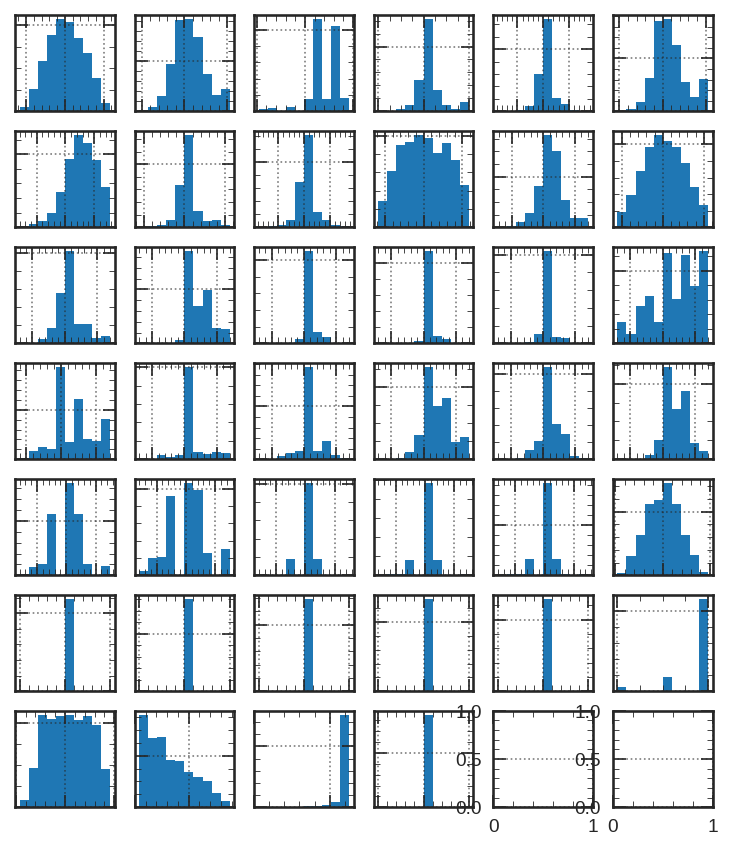

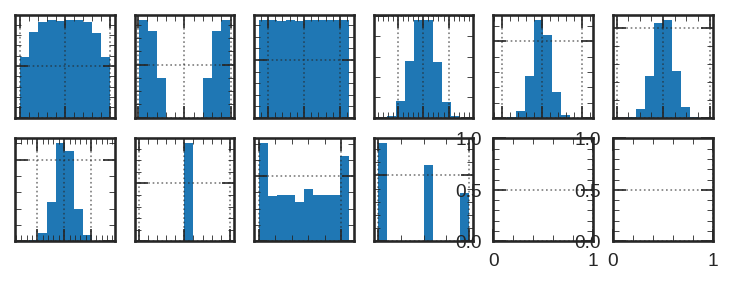

In [22]:
# Plot features and truths
if maxevents == -1:
  xdata = features
  xmask = (features != ma_fill_value())
  latticeplot()

  xdata = truths
  xmask = np.isfinite(truths)
  latticeplot()

In [23]:
# Write to file
if maxevents == -1:
  outfile = 'features.h5'
  outdict = {'features': da.from_array(features), 'truths': da.from_array(truths)}
  da.to_hdf5(outfile, outdict, compression='lzf')
  logger.info('Wrote to {}'.format(outfile))

[INFO    ] Wrote to features.h5
